In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/butterfly-images40-species")

print("Path to dataset files:", path)

100%|██████████| 399M/399M [00:04<00:00, 97.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13"
print(os.listdir(dataset_path))


['valid', 'training.csv.csv', 'test', 'train', 'EfficientNetB0-100-(224 X 224)- 97.59.h5', 'butterflies and moths.csv']


In [3]:
import torch # framework for building and training deep learning models
import torch.nn as nn   # neural network module like layers and activation functions.
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms   # Helps in preprocessing image datasets (resizing, normalizing
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/train", transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/valid", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/test", transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs=50, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, valid_losses, test_losses = [], [], []
    train_accuracies, valid_accuracies, test_accuracies = [], [], []
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  #reset the gradients of all model parameters before computing the next set of gradients during backpropagation.
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  #computes the gradients of the loss with respect to the model parameters using backpropagation.
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            progress_bar.set_postfix(loss=running_loss / (total / 32), acc=100. * correct / total)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation phase
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(100. * correct / total)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Valid Acc: {valid_accuracies[-1]:.2f}%')

        # Early stopping check
        if valid_losses[-1] < best_valid_loss:
            best_valid_loss = valid_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, valid_losses, test_losses, train_accuracies, valid_accuracies, test_accuracies

# Initialize and train model
model = CNN()
train_losses, valid_losses, test_losses, train_accuracies, valid_accuracies, test_accuracies = train_model(model, train_loader, valid_loader, test_loader)

Epoch 1/50: 100%|██████████| 394/394 [01:11<00:00,  5.52it/s, acc=8.93, loss=4.2]


Epoch 1/50, Train Loss: 4.1995, Valid Loss: 3.3308, Train Acc: 8.93%, Valid Acc: 21.80%


Epoch 2/50: 100%|██████████| 394/394 [01:08<00:00,  5.73it/s, acc=26.8, loss=3.03]


Epoch 2/50, Train Loss: 3.0276, Valid Loss: 2.9413, Train Acc: 26.80%, Valid Acc: 28.00%


Epoch 3/50: 100%|██████████| 394/394 [01:10<00:00,  5.59it/s, acc=50.3, loss=1.99]


Epoch 3/50, Train Loss: 1.9838, Valid Loss: 3.0843, Train Acc: 50.30%, Valid Acc: 28.20%


Epoch 4/50: 100%|██████████| 394/394 [01:09<00:00,  5.67it/s, acc=77.3, loss=0.849]


Epoch 4/50, Train Loss: 0.8481, Valid Loss: 4.2199, Train Acc: 77.27%, Valid Acc: 28.80%


Epoch 5/50: 100%|██████████| 394/394 [01:08<00:00,  5.72it/s, acc=92.3, loss=0.283]


Epoch 5/50, Train Loss: 0.2829, Valid Loss: 5.7833, Train Acc: 92.27%, Valid Acc: 25.80%


Epoch 6/50: 100%|██████████| 394/394 [01:08<00:00,  5.73it/s, acc=96.2, loss=0.146]


Epoch 6/50, Train Loss: 0.1456, Valid Loss: 6.0607, Train Acc: 96.24%, Valid Acc: 27.00%


Epoch 7/50: 100%|██████████| 394/394 [01:09<00:00,  5.71it/s, acc=97.2, loss=0.102]


Epoch 7/50, Train Loss: 0.1021, Valid Loss: 7.0241, Train Acc: 97.21%, Valid Acc: 25.00%
Early stopping at epoch 7


# Evaluate the  model

In [14]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():  # Disable gradient computation for faster inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class index with the highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [15]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 24.60%


# Enhance Model Accuracy

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Updated Transformations with Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Dataset
train_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/train", transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/valid", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [17]:
# ✅ Use Pretrained Model (ResNet18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_dataset.classes))
)
model = model.to(device)

# ✅ Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR every 10 epochs

# ✅ Training Function
def train_model(model, train_loader, valid_loader, num_epochs=50, patience=5):
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            progress_bar.set_postfix(loss=running_loss / (total / 32), acc=100. * correct / total)

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        valid_acc = 100. * correct / total
        valid_loss /= len(valid_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}, Train Acc = {train_acc:.2f}%, Valid Acc = {valid_acc:.2f}%")

        # Early Stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()  # Adjust learning rate

# ✅ Train the Model
train_model(model, train_loader, valid_loader)

# ✅ Load the Best Model
model.load_state_dict(torch.load("best_model.pth"))

# ✅ Testing Function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    class_names = test_loader.dataset.classes  # Get class names
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

# ✅ Test the Model
test_model(model, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.9MB/s]
Epoch 1/50: 100%|██████████| 394/394 [01:33<00:00,  4.23it/s, acc=51, loss=2.41]


Epoch 1: Train Loss = 2.4119, Valid Loss = 0.5505, Train Acc = 51.03%, Valid Acc = 89.40%


Epoch 2/50: 100%|██████████| 394/394 [01:31<00:00,  4.30it/s, acc=85.4, loss=0.613]


Epoch 2: Train Loss = 0.6122, Valid Loss = 0.2740, Train Acc = 85.42%, Valid Acc = 93.40%


Epoch 3/50: 100%|██████████| 394/394 [01:28<00:00,  4.48it/s, acc=91.1, loss=0.361]


Epoch 3: Train Loss = 0.3604, Valid Loss = 0.2186, Train Acc = 91.05%, Valid Acc = 94.40%


Epoch 4/50: 100%|██████████| 394/394 [01:32<00:00,  4.25it/s, acc=93, loss=0.271]


Epoch 4: Train Loss = 0.2703, Valid Loss = 0.2118, Train Acc = 93.04%, Valid Acc = 94.20%


Epoch 5/50: 100%|██████████| 394/394 [01:30<00:00,  4.35it/s, acc=94.6, loss=0.211]


Epoch 5: Train Loss = 0.2108, Valid Loss = 0.2327, Train Acc = 94.62%, Valid Acc = 94.00%


Epoch 6/50: 100%|██████████| 394/394 [01:28<00:00,  4.44it/s, acc=95.4, loss=0.176]


Epoch 6: Train Loss = 0.1754, Valid Loss = 0.1832, Train Acc = 95.38%, Valid Acc = 95.40%


Epoch 7/50: 100%|██████████| 394/394 [01:29<00:00,  4.40it/s, acc=96.1, loss=0.149]


Epoch 7: Train Loss = 0.1491, Valid Loss = 0.1852, Train Acc = 96.10%, Valid Acc = 95.60%


Epoch 8/50: 100%|██████████| 394/394 [01:30<00:00,  4.37it/s, acc=96.7, loss=0.119]


Epoch 8: Train Loss = 0.1188, Valid Loss = 0.1873, Train Acc = 96.70%, Valid Acc = 95.80%


Epoch 9/50: 100%|██████████| 394/394 [01:29<00:00,  4.38it/s, acc=97.2, loss=0.101]


Epoch 9: Train Loss = 0.1012, Valid Loss = 0.1872, Train Acc = 97.18%, Valid Acc = 95.20%


Epoch 10/50: 100%|██████████| 394/394 [01:28<00:00,  4.47it/s, acc=97, loss=0.102]


Epoch 10: Train Loss = 0.1017, Valid Loss = 0.2194, Train Acc = 97.05%, Valid Acc = 96.00%


Epoch 11/50: 100%|██████████| 394/394 [01:29<00:00,  4.38it/s, acc=98.5, loss=0.0595]


Epoch 11: Train Loss = 0.0595, Valid Loss = 0.1928, Train Acc = 98.51%, Valid Acc = 96.20%
Early stopping at epoch 11


<ipython-input-17-1ce180241826>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 96.80%


96.8

In [18]:
# ✅ Function to Predict Class of an Image
def predict_image(image_path, model):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_names = test_loader.dataset.classes
    predicted_class = class_names[predicted.item()]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# ✅ Test on a Single Image
image_path = "/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/test/ADONIS/1.jpg"
predict_image(image_path, model)

Predicted Class: ADONIS


'ADONIS'

# Predict the Image Class and Visulize

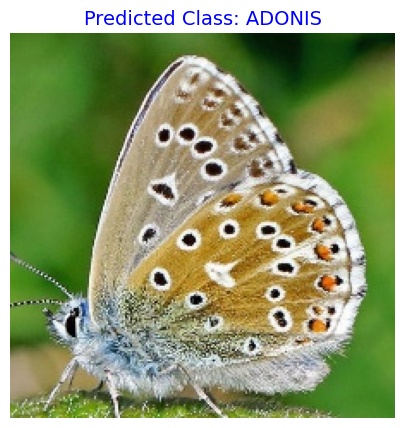

'ADONIS'

In [20]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Function to Predict and Visualize
def predict_and_visualize(image_path, model):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_names = test_loader.dataset.classes
    predicted_class = class_names[predicted.item()]

    # ✅ Display Image with Prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class}", fontsize=14, color="blue")
    plt.show()

    return predicted_class

# ✅ Test on a Single Image
image_path = "/root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13/test/ADONIS/1.jpg"
predict_and_visualize(image_path, model)


# Save Model

In [21]:
# Save the trained model
torch.save(model.state_dict(), "butterfly_classifier_Project.pth")
print("Model saved successfully!")


Model saved successfully!


In [22]:
import os

# Define the filename
model_filename = "butterfly_classifier_Project.pth"

# Get the absolute path
model_path = os.path.abspath(model_filename)

# Save the model
torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/butterfly_classifier_Project.pth
